# Predicting Inspection Results
---

## Objectives

- I am tackling a binary classification problem involving restaurant health inspections using the data I processed in `01_EDA`.
- The two classes I am trying to predict will be Pass/Fail.
- I will aim to optimize my model for **recall** (*AKA sensitivity or true positive rate*) since missing a positive case (inspection failure) could have significant consequences, akin to missing a diagnosis or not detecting a dangerous item going through a metal detector.

---

### Imports

In [162]:
import ast # for evaluating violation codes column properly

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve)

In [4]:
# Setting pandas to display all columns.
pd.set_option('display.max_columns', None)

---
### Load Dataset

In [132]:
file_path = '../../data/processed_chicago.csv'

In [134]:
chicago = pd.read_csv('../../data/processed_chicago.csv')
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,Pass,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000


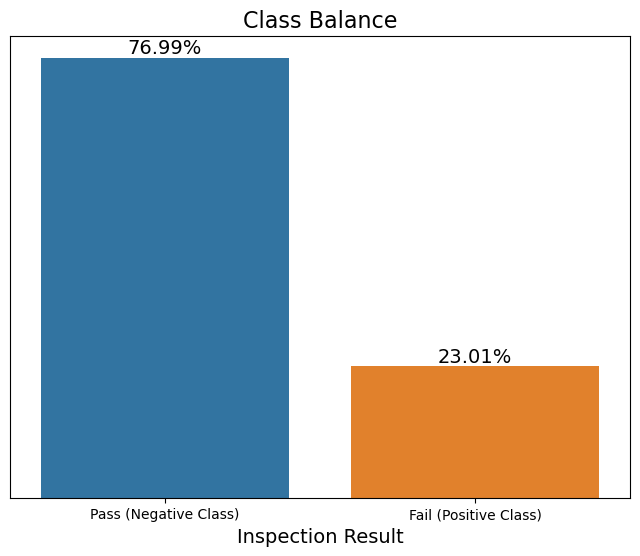

In [10]:
# Baseline Accuracy (as bar chart)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x = ['Pass (Negative Class)', 'Fail (Positive Class)'],
                 y = chicago['results'].value_counts().values,
                 hue = chicago['results'].value_counts().index,
                 legend = False)
# Annotated bars
for i, val in enumerate(chicago['results'].value_counts().values):
    count_norm = chicago['results'].value_counts(normalize=True)[i]
    ax.text(i, val + 0.1,
            f"{count_norm:.2%}",
            ha = 'center',
            va = 'bottom',
            fontsize = 14)
    
plt.title("Class Balance", fontsize=16)
plt.xlabel("Inspection Result", fontsize=14)
plt.yticks([], []); # to remove y tick values

---
- I have chosen `Fail` as our positive class because our features are health codes which were broken, so it would make more intuitive sense to have my coefficients be interpretable as *'Breaking this code makes you this % more likely to fail'* in order to place emphasis on the major health codes to avoid breaking.

---
# Defining Functions

In [14]:
def evaluate_model(model, X_test, y_test, threshold = 0.5):
    '''
    TBD
    '''
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'Recall': recall_score(y_test, y_pred, pos_label = 1, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, pos_label = 1, zero_division=0)
    }
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label = 1)
    auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label = f'ROC Curve (AUC = {auc:.2f})', color = 'blue', linewidth = 2)
    axes[0].plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc = 'lower right')

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels = [1, 0])
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Fail', 'Pass'], yticklabels = ['Fail', 'Pass'],
                cbar = False, ax = axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    axes[1].set_title('Confusion Matrix')

    plt.tight_layout()
    plt.show();

    return metrics

In [16]:
def get_odds(model):
    '''
    TBD
    '''
    features = model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.named_steps['classifier'].coef_.flatten()
    
    coeff_df = pd.DataFrame({
        'Feature': features,
        'Odds': np.exp(coefficients)
    }).sort_values(by = 'Odds', ascending = False)
    
    # Filter to only show violation codes as that's what I'd like to interpret
    coeff_df = coeff_df[coeff_df['Feature'].str.contains('violation_code')]
    # Clean up names a bit
    coeff_df['Feature'] = coeff_df['Feature'].str.replace('remainder__', '')

    return coeff_df

In [18]:
# Instantiating DataFrame to store all results in order to be compared upon later
model_results = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

---
### Preprocessing

In [136]:
# Encoding class labels (Pass = 0, Fail = 1)
chicago['results'] = chicago['results'].map({'Pass': 0, 'Fail': 1})
chicago['results'].value_counts(normalize = True)

results
0    0.769921
1    0.230079
Name: proportion, dtype: float64

In [138]:
# The cleanest solution I've found to handle the violation_codes column getting treated as a string.
chicago['violation_codes'] = chicago['violation_codes'].apply(ast.literal_eval)

# Flatten and get all unique violation codes
unique_codes = sorted(set(code for codes in chicago['violation_codes'] for code in codes))

# Hard coding one-hot encoded columns
for code in unique_codes:
    column_name = f"violation_code_{code}"
    chicago[column_name] = chicago['violation_codes'].apply(lambda x: 1 if code in x else 0)

chicago.shape

(61705, 82)

In [139]:
# Checking codes were properly encoded
chicago.head(3)

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,inspection_date,inspection_type,results,violations,name_cleaned,num_inspections,violation_count,violation_codes,severity_levels,is_reinspection,average_severity,violation_code_1,violation_code_2,violation_code_3,violation_code_4,violation_code_5,violation_code_6,violation_code_7,violation_code_8,violation_code_9,violation_code_10,violation_code_11,violation_code_12,violation_code_13,violation_code_14,violation_code_15,violation_code_16,violation_code_17,violation_code_18,violation_code_19,violation_code_20,violation_code_21,violation_code_22,violation_code_23,violation_code_24,violation_code_25,violation_code_26,violation_code_27,violation_code_28,violation_code_29,violation_code_30,violation_code_31,violation_code_32,violation_code_33,violation_code_34,violation_code_35,violation_code_36,violation_code_37,violation_code_38,violation_code_39,violation_code_40,violation_code_41,violation_code_42,violation_code_43,violation_code_44,violation_code_45,violation_code_46,violation_code_47,violation_code_48,violation_code_49,violation_code_50,violation_code_51,violation_code_52,violation_code_53,violation_code_54,violation_code_55,violation_code_56,violation_code_57,violation_code_58,violation_code_59,violation_code_60,violation_code_61,violation_code_62,violation_code_63,violation_code_64
0,2606026,FAMOUS GRILL,SAM'S FAMOUS GRILL,2961604,Restaurant,Risk 1 (High),2926 W 63RD ST,2024-11-06,Required Inspection to Open,0,No Violations,SAMS FAMOUS GRILL,4,0,[],[],False,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2605995,DUNKIN DONUTS,DUNKIN DONUTS,2835421,Restaurant,Risk 2 (Medium),1465 W 95TH ST,2024-11-06,Standard Re-Inspection,0,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,DUNKIN DONUTS,13,7,"[39, 39, 41, 47, 49, 53, 55]","[4, 4, 4, 5, 4, 8, 1]",True,4.285714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,2606039,STARBUCKS COFFEE #13710,STARBUCKS,1843207,Restaurant,Risk 2 (Medium),30 W ERIE ST,2024-11-06,Standard Inspection,1,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",STARBUCKS,8,4,"[38, 52, 55, 55]","[4, 8, 1, 1]",False,3.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [140]:
# Ordinal encoding for risk
risk_mapping = {'Risk 1 (High)': 3, 'Risk 2 (Medium)': 2, 'Risk 3 (Low)': 1}
chicago['risk'] = chicago['risk'].map(risk_mapping)
chicago['risk']

0        3
1        2
2        2
3        3
4        3
        ..
61700    2
61701    2
61702    3
61703    3
61704    2
Name: risk, Length: 61705, dtype: int64

In [144]:
# Creating X and y
X = chicago.drop(columns=['inspection_id', 'dba_name', 'aka_name', 'license', 'facility_type', 'address', 'inspection_date', 'results',
       'violations', 'name_cleaned', 'violation_codes', 'severity_levels'])
y = chicago['results']

In [146]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [148]:
# Since one-hot encoding and ordinal encoding are already applied, only scale numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', StandardScaler(), ['num_inspections', 'violation_count', 'average_severity']),
        ('ohe', OneHotEncoder(), ['inspection_type'])
    ],
    remainder='passthrough'  # Keep the already preprocessed columns as they are
)

---
# Iteration 1

### Modelling

In [37]:
# Model pipeline
pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, random_state = 42))
])

In [47]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__C': [.001, .01, .1, 1, 10, 100, 1000],
    'classifier__penalty': ['l2', 'l2'],
    'classifier__solver': ['saga', 'liblinear']
}

grid_search_1 = GridSearchCV(pipeline_1, param_grid, cv = 5, scoring = 'recall', verbose = 1, n_jobs = -1)
grid_search_1.fit(X_train, y_train)

# Best model
model_1 = grid_search_1.best_estimator_
print(f'Best Parameters: {grid_search_1.best_params_}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}


---
### Model Evaluation

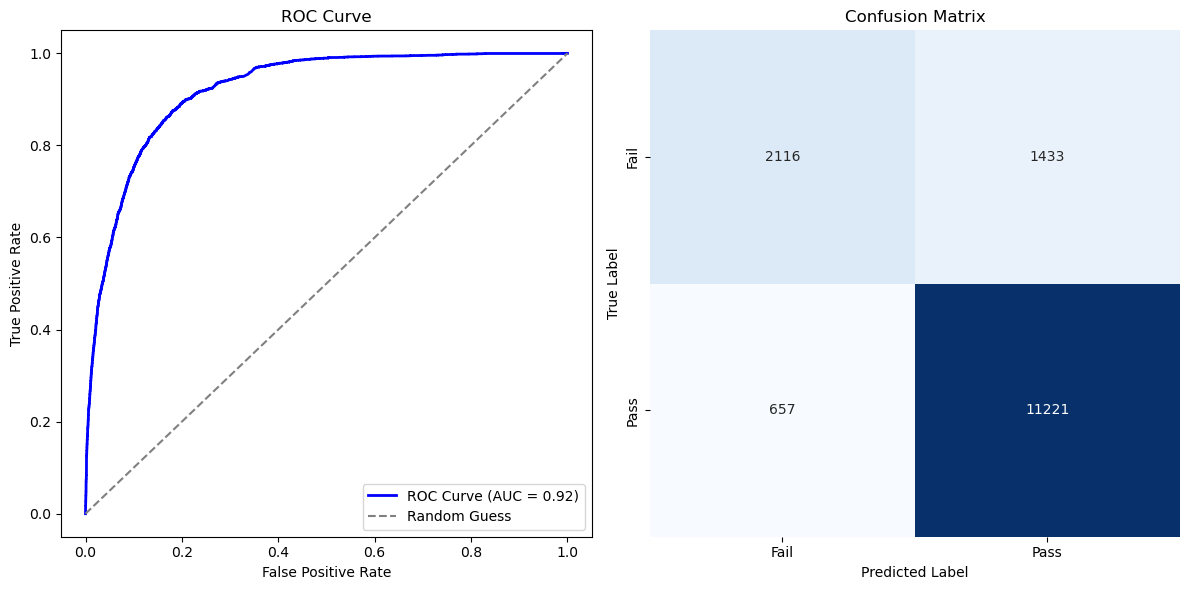

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.864523,0.763072,0.596224,0.669408


In [52]:
# Evaluation
model_results.loc['First_Iteration_LR'] = evaluate_model(model_1, X_test, y_test) # default threshold of 0.5
model_results

---
### Interpretations

I must address the assumptions I could be breaking before interpreting these coefficients.

**For example:**

- Independent Observations: Since our dataset could have multiple inspections for a single restaurant, this could mean our observations are not independent of each other. For example, a restaurant re-inspection would be related to the first inspection in terms of what violations (our explanatory variable) are being examined.

- On a similar note, multicollinearity must be happening in our violations as they are inherently grouped by category (Physical Facilities, Prevention of Food Contamination, Employee Health, etc.). For example, if a restaurant is cited for improper reheating procedures (Health Code 19), the common demoninator here is an unawareness of proper temperature control which means they are likely to also not be following proper cooling procedures (Health Code 20).

In [54]:
coeffs = get_odds(model_1)

# 10 Violation Codes with highest odds for failed inspection according to my model
coeffs.head(10)

,Feature,Odds
71,violation_code_59,263.571265
72,violation_code_60,13.763293
50,violation_code_38,12.946040
62,violation_code_50,9.962649
60,violation_code_48,5.593051
66,violation_code_54,4.633910
37,violation_code_25,3.236711
64,violation_code_52,2.998492
28,violation_code_16,2.732020
36,violation_code_24,2.385441


**Violation Code 59:** *Previous priority foundation violation corrected*

- "Priority violations create an immediate health hazard that carry a high-risk of causing food-borne illness. Priority violations must be corrected immediately; if they cannot be corrected immediately, the license will be suspended, and the food establishment must close" [source](https://www.chicago.gov/city/en/depts/cdph/provdrs/food_safety/svcs/understand_healthcoderequirementsforfoodestablishments.html)

- My model is able to recognize one of the major reasons for failing an inspection which is a good sign.

**Violation Code 38:** *Insects, rodents, & animals not present*
- A restaurant is 12.9 times more likely to fail if there are rodents present according to my model.

---
## Conclusion

- A suprisingly high accuracy for our first iteration of modelling. However I am not impressed with the amount of false negatives.
- In my second model I need to consider different methods for ensuring I can achieve higher recall than my first iteration, as ~60% is too low.
- For my second iteration I have introduced the threshold argument to my `evaluate_model` function and for further control of my model so hopefully I can find the sweet spot there.

---

# Iteration 2

### Modelling

In [63]:
# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty = 'l2', solver = 'saga', max_iter = 1000, random_state = 42))
])

In [71]:
# Searching optimal alpha
param_grid = {
    'classifier__C': np.linspace(1, 20, 20),
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'recall', verbose = 1, n_jobs = -1)
grid_search_2.fit(X_train, y_train)

# Best model
model_2 = grid_search_2.best_estimator_
print(f'Best Parameters: {grid_search_2.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'classifier__C': 5.0}


---
### Model Evaluation

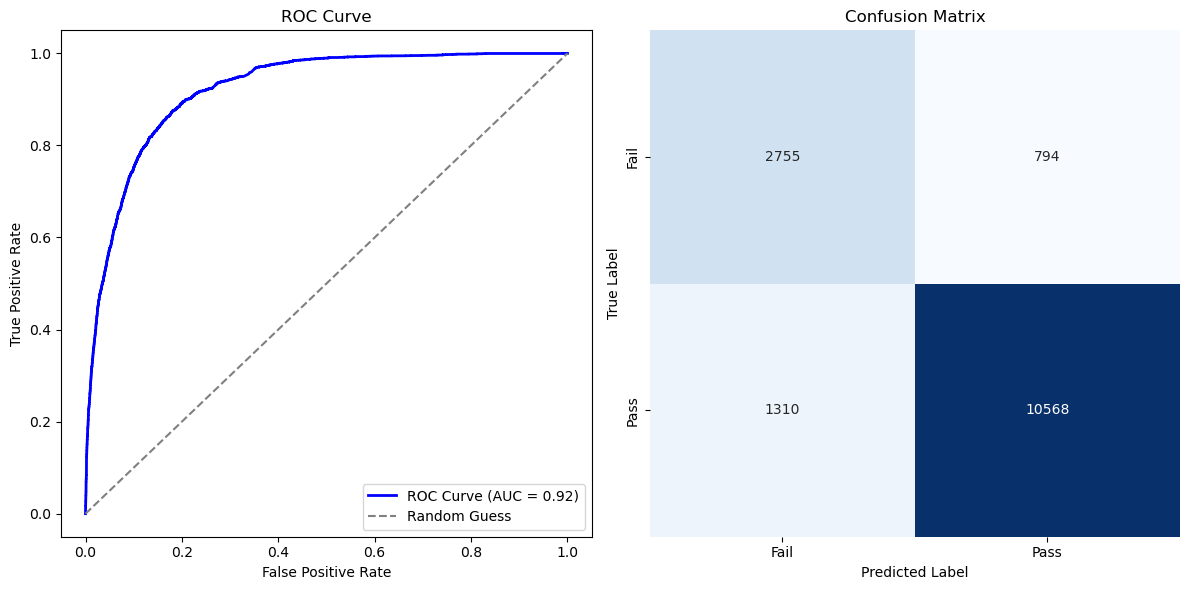

,Accuracy,Precision,Recall,F1 Score
First_Iteration_LR,0.864523,0.763072,0.596224,0.669408
Second_Iteration_LR,0.863616,0.677737,0.776275,0.723667


In [66]:
# Evaluation
model_results.loc['Second_Iteration_LR'] = evaluate_model(model_2, X_test, y_test, threshold = 0.3) # changing threshold in hopes of improving recall
model_results

---
### First vs Second Iteration

- Taking advantage of predict_proba() to define a threshold for the predictions of my model effectively halved the amount of false negatives, and while precision naturally takes a hit, the recall and overall F1 score has improved.

- Given the class imbalance, an accuracy rate of 86.4% is not as impressive as it seems seeing as we could predict Pass every time and get a baseline accuracy of roughly 76%. However it is reassuring to know we have beat the baseline accuracy.

- In my final iteration of this model, I will attempt something new for me which is threshold tuning, while accounting for highest accuracy possible.

---
# Final Iteration (Threshold Tuning)

In [150]:
# Fit logistic regression pipeline with best parameters form Grid Search CV
pipeline_prod = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C = 5, solver = 'saga', penalty = 'l2', max_iter = 1000, random_state = 42))
])

pipeline_prod.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  ['num_inspections',
                                                   'violation_count',
                                                   'average_severity']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['inspection_type'])])),
                ('classifier',
                 LogisticRegression(C=5, max_iter=1000, random_state=42,
                                    solver='saga'))])

In [175]:
# Generate predicted probabilities
probs = pipeline_prod.predict_proba(X_test)[:, 1]

In [210]:
# Calculate recision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# list comp for accuracies for each threshold, converted to numpy array so I can use to some np functions on it
accuracies = np.array([accuracy_score(y_test, (probs >= t).astype(int)) for t in thresholds])

In [211]:
# taking advantage of numpy functions to find the thresholds where accuracy does not drop below a certain number

good_thresholds = np.where(accuracies >= 0.85)[0] # 85 is the lowest accuracy I will accept

best_threshold = thresholds[good_thresholds[np.argmax(recall[good_thresholds])]]

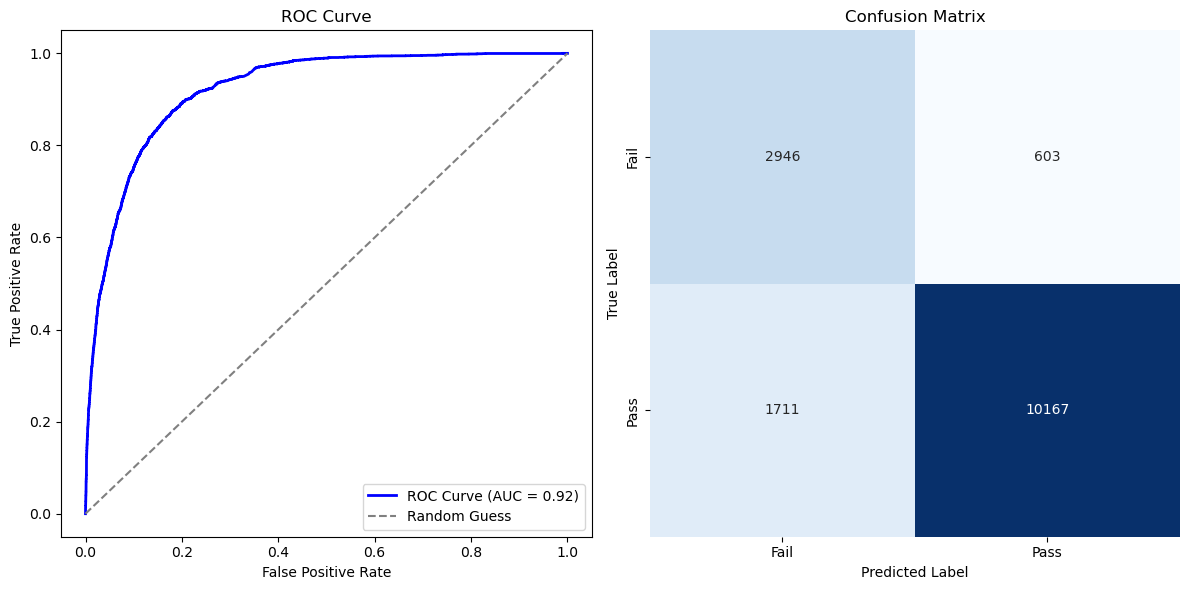

,Accuracy,Precision,Recall,F1 Score,Third_Iteration_LR
First_Iteration_LR,0.864523,0.763072,0.596224,0.669408,NaN
Second_Iteration_LR,0.863616,0.677737,0.776275,0.723667,NaN
Third_Iteration_LR,0.850003,0.632596,0.830093,0.718011,NaN


In [212]:
model_results.loc['Third_Iteration_LR'] = evaluate_model(pipeline_prod, X_test, y_test, threshold = best_threshold)
model_results

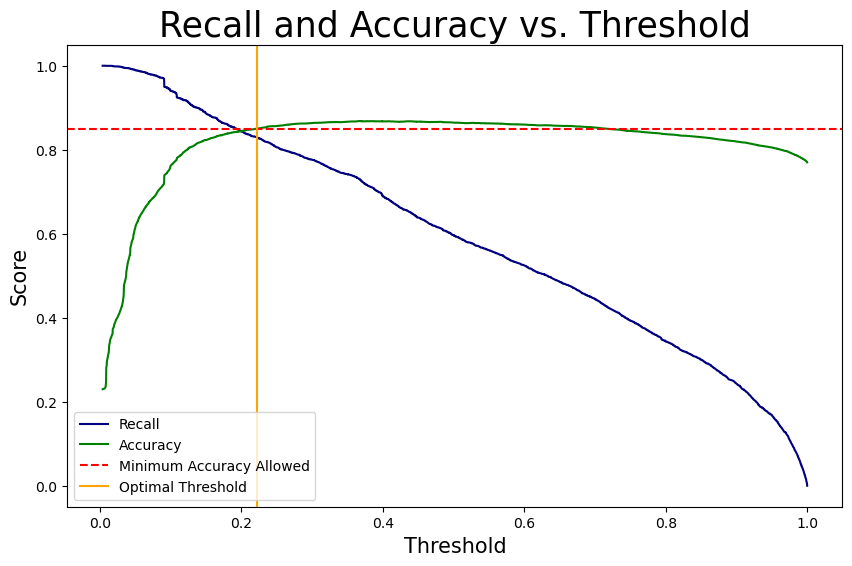

In [213]:
# Visualization of what we just calculated
plt.figure(figsize=(10, 6))

plt.plot(thresholds, recall[:-1], label = 'Recall', color = 'navy')
plt.plot(thresholds, accuracies, label = 'Accuracy', color = 'green')
plt.axhline(y = 0.85, color = 'red', linestyle = '--', label = 'Minimum Accuracy Allowed')
plt.axvline(x = best_threshold, color = 'orange', linestyle = '-', label = 'Optimal Threshold')

plt.title('Recall and Accuracy vs. Threshold', size = 25)
plt.xlabel('Threshold', size = 15)
plt.ylabel('Score', size = 15)



plt.legend(loc = 'lower left');

---
# Modelling Conclusion

**Preprocessing:**
- Due the list-like nature of my engineered columns such as `violation_codes`, it posed a syntactical challenge in trying to get this feature matrix in the right shape and format to be fit for sklearn's libraries. That is why in the end I opted to just hard code the OHE for this column specifically, for the sake of time. Hindsight is 20/20, and having ran into these issues during the modelling and app phases of my project I would have created my features in a much different way. So that was a good learning experience.

**Modelling:**

- At first I chose logistic regression for the purposes of interpretation, so that restaurant owners could better understand what factors contribute the most to the success/failure of an inspection. Quickly I realized how many assumptions my dataset could be breaking and so interpretations are to be taken with a grain of salt until I research a way to solve this 'assumptions' problem.

**Future Models:**
- One other option is to dive fully into a 'black box' model. With no interpretability, the most effective use of this model could be on the inspection department's side in order to verify grades or in some way expedite the inspection process, but there could be some very bad consequences to that, which is why I intially steered away from that goal. I have enough experience with health inspectors to say that it is frustrating when your kitchen gets cited for some small thing just because the inspector isn't in a good mood or doesn't particularly like you. A model wouldn't have this bias and could grade the restaurant objectively, which is one potential bonus. But on the other hand a model might not be able to pick up many nuances of the restaurant trade which must be taken into context when assessing potential violations. And without understanding how the model reached that conclusion, this could be a big problem very quickly and in fact cause more foodborne outbreaks or encouragement of unhealthy practices. I wouldn't even want to think of the legal problems.

---
